# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import torch
import time
from itertools import count
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

ModuleNotFoundError: No module named 'unityagents'

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Train the agent

In [5]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=2)
avg_over = 100

In [6]:
def ddpg(n_episodes=1000, print_every=1):
    scores_deque = deque(maxlen=avg_over)
    scores_global = []
    average_global = []
    best_avg = -np.inf
    solved = False

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        agent.reset()

        score_average = 0
        for t in count():
            actions = agent.act(states, add_noise=True)
            env_info = env.step(actions)[brain_name]      # send the action to the environment
            next_states = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones, t)
            states = next_states
            scores += rewards
            if np.any(dones):                           # exit loop if episode finished
                break
                
        score = np.mean(scores)
        scores_deque.append(score)
        score_average = np.mean(scores_deque)
        scores_global.append(score)
        average_global.append(score_average)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        
        if i_episode % print_every == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
        if score_average >= 30.0:
            if not solved:
                solved = True
                torch.save(agent.actor_local.state_dict(), 'best_checkpoint_actor.pth')
                torch.save(agent.critic_local.state_dict(), 'best_checkpoint_critic.pth')
                print('\nEnvironment solved in {:d} episodes!'.format(i_episode))
                break
            
    return scores_global, average_global

scores, averages = ddpg()


/Users/simon/dev/ddpg-continuous-control-udacity/ddpg_agent.py:129: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 1	Average Score: 0.63
Episode 2	Average Score: 0.81
Episode 3	Average Score: 0.80
Episode 4	Average Score: 0.89
Episode 5	Average Score: 0.85
Episode 6	Average Score: 0.88
Episode 7	Average Score: 0.91
Episode 8	Average Score: 0.93
Episode 9	Average Score: 0.93
Episode 10	Average Score: 0.92
Episode 11	Average Score: 0.90
Episode 12	Average Score: 0.89
Episode 13	Average Score: 0.89
Episode 14	Average Score: 0.90
Episode 15	Average Score: 0.91
Episode 16	Average Score: 0.93
Episode 17	Average Score: 0.96
Episode 18	Average Score: 0.99
Episode 19	Average Score: 1.05
Episode 20	Average Score: 1.08
Episode 21	Average Score: 1.15
Episode 22	Average Score: 1.21
Episode 23	Average Score: 1.29
Episode 24	Average Score: 1.34
Episode 25	Average Score: 1.38
Episode 26	Average Score: 1.47
Episode 27	Average Score: 1.56
Episode 28	Average Score: 1.72
Episode 29	Average Score: 1.89
Episode 30	Average Score: 2.05
Episode 31	Average Score: 2.27
Episode 32	Average Score: 2.58
Episode 33	Averag

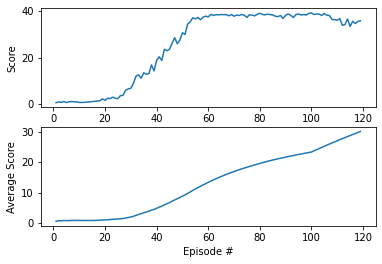

In [7]:
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')

plt.subplot(2, 1, 2)
plt.plot(np.arange(1, len(scores)+1), averages)
plt.ylabel('Average Score')
plt.xlabel('Episode #')
plt.show()

### 4. Watch a smart agent

In [ ]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

env_info = env.reset(train_mode=False)[brain_name]

## Watch the agent performing in the environment
scores_episode = np.zeros(num_agents)
for i in range(5000):
    actions = agent.act(states, add_noise=False)
    env_info = env.step(actions)[brain_name]
    states = env_info.vector_observations
    rewards = env_info.rewards
    scores_episode += rewards

print('Score for this episode: {:.2f}'.format(scores_episode.mean()))

In [ ]:
env.close()